In [0]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/DeepLearningLabs/Lab5/data/'
myDrive = '/content/drive/My Drive/DeepLearningLabs/Lab5/data/'
myRoot = '/content/drive/My Drive/DeepLearningLabs/Lab5/'
%run /content/drive/My\ Drive/DeepLearningLabs/Lab5/Datasets.py

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
AEMnist  CK  CVAECK  GANCK  GANMnist  mnist  MNIST_DAE	samples


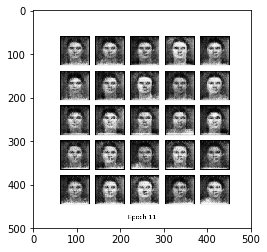

In [0]:
#Example result 
from PIL import Image
import matplotlib.pyplot as plt

#Example results 
epoch = 1
resName = myDrive+'GANCK/fr/CK_DCGAN_11.png'
plt.imshow(Image.open(resName))

Here we import the required dependencies

In [0]:
from PIL import Image

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt


In [0]:
# Training parameters
data_root = myDrive + '/CK'
workers = 2
batch_size = 128
image_size = 64

num_channels = 3 #rgb
z_size = 100 # Size of the latent vector

feature_map_size = 64

num_epochs = 5
lr = 0.0002
beta1 = 0.5 #for Adam optimizers

device = 'cuda' if torch.cuda.is_available else 'cpu'

fixed_noise = torch.randn(batch_size, z_size, 1, 1).to(device)
real_label = torch.ones(batch_size).to(device)
fake_label = torch.zeros(batch_size).to(device)


transform=transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)), # bring images to (-1,1)
        ])

print(device)

cuda


Here we define the Generator. We have used the same model presented in DCGAN.

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d( z_size, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),

            nn.ConvTranspose2d( feature_map_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

Here we define the discriminator based on PatchGAN

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(num_channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Here we define the Dataset class

In [0]:
# mean=0, stdev=0.2.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class CKDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.transform = transform
        self.imgs_path = []

        # Get img paths
        for root, dirs, files in os.walk(root):
            for f in files:
                self.imgs_path.append(os.path.join(root, f))

    def __getitem__(self, index):
        img = self.imgs_path[index]
        img = Image.open(img).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.imgs_path)

In [0]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [0]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr*2, betas=(beta1, 0.999))

In [0]:
ck_dataset = CKDataset(data_root, transform)
print(len(ck_dataset), "images")
dataloader = torch.utils.data.DataLoader(ck_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers,
                                        drop_last = True)

6849 images


In [0]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        # Train Discriminator
        optimizerD.zero_grad()

        real_image = data.to(device)
        d_real_output = discriminator(real_image).view(-1)
        loss_d_real = criterion(d_real_output, real_label)
        
        loss_d_real.backward()

        noise = torch.randn(batch_size, z_size, 1, 1, device=device)
        fake_image = generator(noise)
        
        d_fake_output = discriminator(fake_image.detach()).view(-1)
        loss_d_fake = criterion(d_fake_output, fake_label)

        loss_d_fake.backward()
        optimizerD.step()
        
        d_loss = loss_d_real + loss_d_fake

        # Train the generator
        optimizerG.zero_grad()
        
        g_d_fake_output = discriminator(fake_image).view(-1)
        g_loss = criterion(g_d_fake_output, real_label)
        g_loss.backward()
        optimizerG.step()

        # Output training stats
        if i % 5 == 0:
            print(f'{epoch}/{num_epochs} [{i}/{len(dataloader)}]'
                   f'Loss D: {d_loss.item()}, Loss G {g_loss.item()}')

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if i % 10 == 0:
            img_list.append(vutils.make_grid(fake_image, padding=2, normalize=True))

Starting Training Loop...
0/5 [0/53]Loss D: 2.0075416564941406, Loss G 4.255842685699463
0/5 [5/53]Loss D: 0.8818193674087524, Loss G 8.544981956481934
0/5 [10/53]Loss D: 0.9140729904174805, Loss G 13.185650825500488
0/5 [15/53]Loss D: 0.5795432925224304, Loss G 15.897832870483398
0/5 [20/53]Loss D: 0.1004989743232727, Loss G 14.708080291748047
0/5 [25/53]Loss D: 0.1199394017457962, Loss G 11.367237091064453
0/5 [30/53]Loss D: 0.16768299043178558, Loss G 13.055662155151367
0/5 [35/53]Loss D: 0.1457173377275467, Loss G 12.221000671386719
0/5 [40/53]Loss D: 0.8360449075698853, Loss G 16.115314483642578
0/5 [45/53]Loss D: 3.1572940349578857, Loss G 24.63304328918457
0/5 [50/53]Loss D: 0.4476065933704376, Loss G 8.36280632019043
1/5 [0/53]Loss D: 0.6677770614624023, Loss G 9.005828857421875
1/5 [5/53]Loss D: 0.6726154088973999, Loss G 6.3431782722473145
1/5 [10/53]Loss D: 1.1777124404907227, Loss G 7.413200855255127
1/5 [15/53]Loss D: 1.3374502658843994, Loss G 11.35844612121582
1/5 [20/53

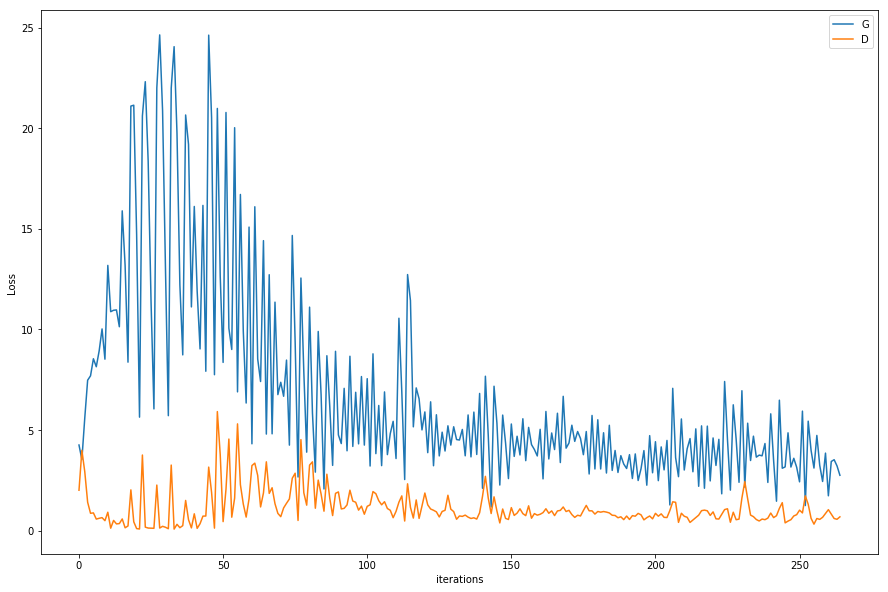

In [0]:
plt.figure(figsize=(15,10))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

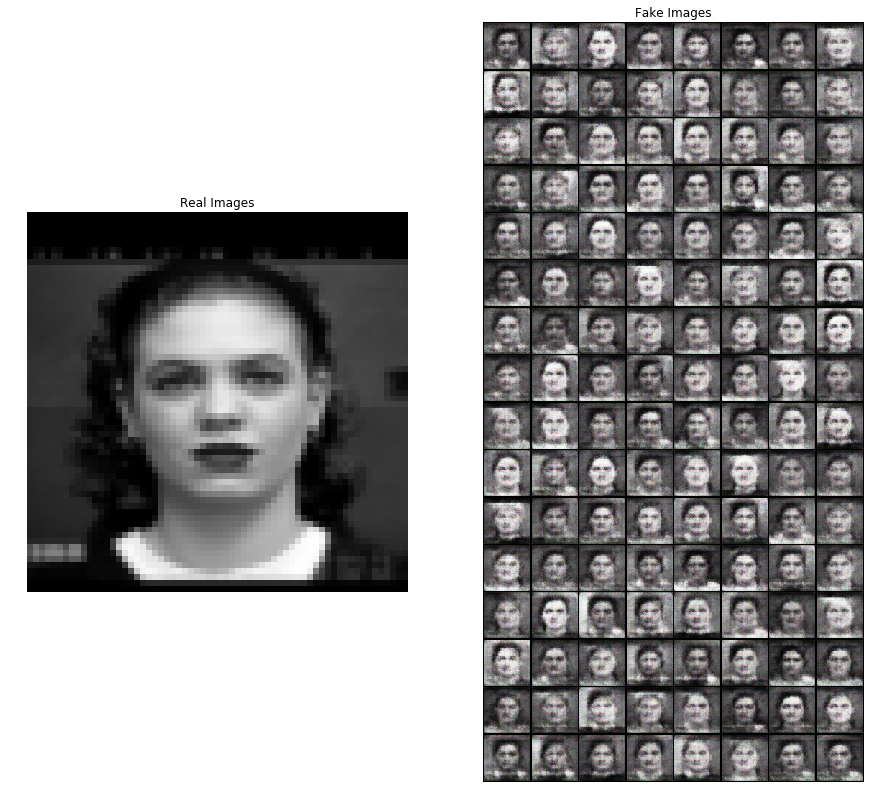

In [0]:
# Grab a batch of real images from the dataloader
real_image = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_image[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()